# Clasificación binaria

paper: https://www.researchgate.net/publication/13865380_Twelve-year_results_of_the_Coronary_Risk_Factor_Study_CORIS

Variables:

|         |                                                       |
|---------|-------------------------------------------------------|
|sbp      |systolic blood pressure                                |
|tobacco  |cumulative tobacco (kg)                                |
|ldl      |low densiity lipoprotein cholesterol                   |
|adiposity|                                                       |
|famhist  |family history of heart disease (Present, Absent)      |
|typea    |type-A behavior                                        |
|obesity  |                                                       |
|alcohol  |current alcohol consumption                            |
|age      |age at onset                                           |
|chd      |response, coronary heart disease                       |


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import transforms, pyplot as plt
%matplotlib inline

# propiedades de las graficas adelantadas 
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY4, GRAY7 = '#646369', '#929497'

## Carga y Preparación de los Datos 

In [ ]:
# Carga de los datos 
df = pd.read_csv("SAHeartDisease.txt")
# codifica la variable famhist con variables dummy 0-1 
df['famhist'] = pd.get_dummies(df['famhist'])['Present']
target = 'chd'
features = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']
df[features + [target]].head()

,sbp,tobacco,ldl,famhist,obesity,alcohol,age,chd
0,160,12.00,5.73,1,25.30,97.20,52,1
1,144,0.01,4.41,0,28.87,2.06,63,1
2,118,0.08,3.48,1,29.14,3.81,46,0
3,170,7.50,6.41,1,31.99,24.26,58,1
4,134,13.60,3.50,1,25.99,57.34,49,1


###### Estudio de correlaciones 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


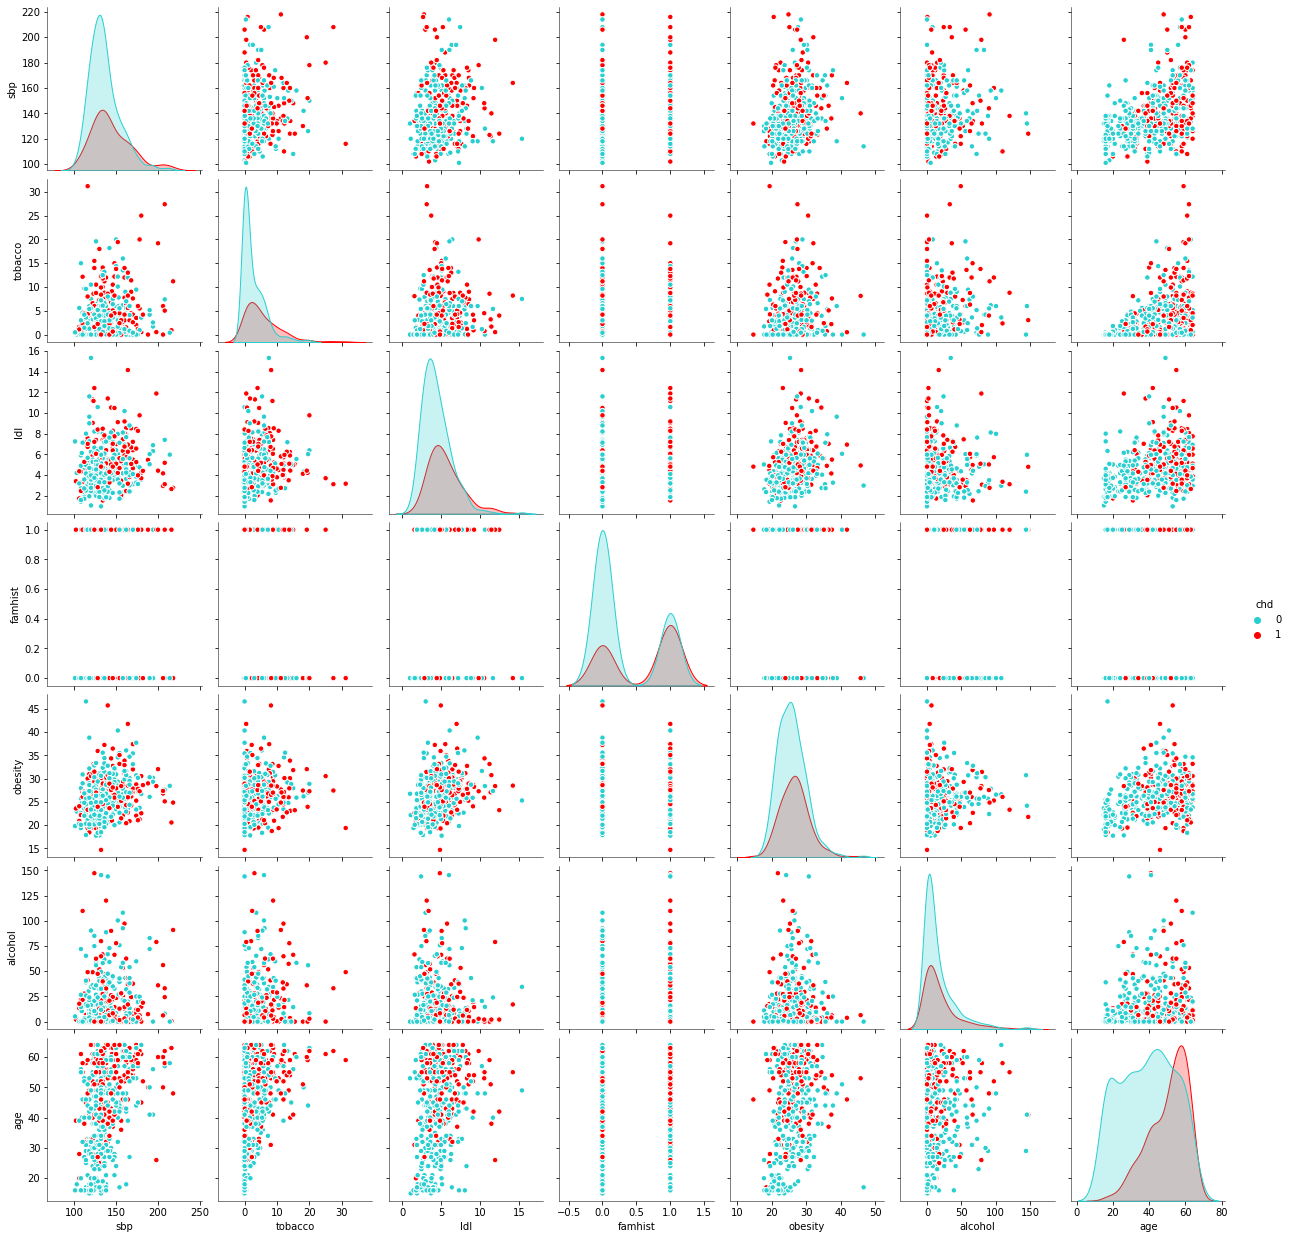

In [ ]:
sns.pairplot(
    df, vars=features, kind="scatter", hue=target,
    palette=['#29CFD0', '#FF0000'], plot_kws=dict(s=30, linewidth=1)
)

{'linewidth': 1, 's': 30}

# Trabajo 1:

Describa con sus propias palabras las gráficas que se visualizan en la matriz de scatterplot

Acá se denota como se reparte cada caracteristica con respecto a las demas y respecto a la variable objetivo.


###### CONTINUANDO: 

In [ ]:
# conversión de datos a matrices y vectores
X, y = df[features].values, df[target].values

## Logistic Regression

In [ ]:
import statsmodels.api as sm
from scipy import stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
lr = sm.Logit(y, sm.add_constant(X)).fit(disp=False)

result = zip(['(Intercepto)'] + features, lr.params, lr.bse, lr.tvalues)
print('               Coeficiente   Std. Error   Z Score')
print('-------------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>12}{coefficient:>14.3f}{std_err:>13.3f}{z_score:>10.3f}')

               Coeficiente   Std. Error   Z Score
-------------------------------------------------
(Intercepto)        -4.130        0.964    -4.283
         sbp         0.006        0.006     1.023
     tobacco         0.080        0.026     3.034
         ldl         0.185        0.057     3.218
     famhist         0.939        0.225     4.177
     obesity        -0.035        0.029    -1.187
     alcohol         0.001        0.004     0.136
         age         0.043        0.010     4.181


## Features Selection

basado en 'residual deviance'.

https://www.dm.uba.ar/materias/modelos_lineales_generalizados_Mae/2005/1/glm5.pdf

In [ ]:
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

In [ ]:
# calcula la deviance total de un modelo sobre un conjunto de datos
def deviance(X, y, model):
    return 2*log_loss(y, model.predict_proba(X), normalize=False)


# calcula la deviance total de un modelo entrenado con un subconjunto de caracteristicas
def subset_deviance(model, selected_ids):
    X_selected = X[:, sorted(list(selected_ids))]
    model.fit(X_selected, y)
    return deviance(X_selected, y, model)


lr = LogisticRegression(solver='lbfgs', max_iter=100000, C=10e10)
# inicia seleccionando todas las caracteristicas
selected_ids = set(range(len(features)))
current_deviance = subset_deviance(lr, selected_ids)
while True:
    # cual es la deviance total si se remueve una caracteristica?
    deviances = [
        (subset_deviance(lr, selected_ids - set([idx])), idx)
        for idx in selected_ids]
    # encuentra una caracteristica para remover para minimizar el resultado de la deviance total
    min_deviance, feature_to_remove_idx = min(deviances)
    # la diferencia entre las deviances para los dos modelos siguen
    # distribucion chi-squared aproximada. Esto se como criterio de parada
    deviance_diff = min_deviance - current_deviance
    p_value = 1 - stats.chi2.cdf(deviance_diff, df=1)
    print(p_value)
    if p_value < 0.05:
        break
    selected_ids -= set([feature_to_remove_idx])
    current_deviance = min_deviance
    print(p_value)
    print(f'REMOVE: {features[feature_to_remove_idx]}')

# nombre de las caracteristicas seleccionadas 
selected_ids = sorted(list(selected_ids))
features_selected = [features[i] for i in selected_ids]

0.8917958253037171
0.8917958253037171
REMOVE: alcohol
0.29334395132399127
0.29334395132399127
REMOVE: sbp
0.284154275250843
0.284154275250843
REMOVE: obesity
0.001615903070590674


# Trabajo 2:

Explique porque se eliminó la variable alcohol

Se eliminó debido a que está dentro del limite  de la distribución chi cuadrada, la cual se está usando en este caso, de esta manera obtendremos un resultado mas confiable.

###### CONTINUANDO: 

#### Se corre la regresión logística 

In [ ]:
# PAGE 124. TABLE 4.3. Results from stepwise logistic regression fit to South
#           African heart disease data.
lr = sm.Logit(y, sm.add_constant(X[:, selected_ids])).fit(disp=False)
result = zip(['(Intercept)']+features_selected, lr.params, lr.bse, lr.tvalues)
print('               Coefficient   Std. Error   Z Score')
print('-------------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>12}{coefficient:>14.3f}{std_err:>13.3f}{z_score:>10.2f}')
type(lr)

               Coefficient   Std. Error   Z Score
-------------------------------------------------
 (Intercept)        -4.204        0.498     -8.44
     tobacco         0.081        0.026      3.16
         ldl         0.168        0.054      3.09
     famhist         0.924        0.223      4.14
         age         0.044        0.010      4.52


statsmodels.discrete.discrete_model.BinaryResultsWrapper

# Trabajo 3:

Interprete el coeficiente 0.081 para el tabaco

Cuál es el intervalo de confianza ?

In [ ]:
lr.conf_int(cols=[1])

array([[0.03069255, 0.13070862]])

In [ ]:
lr.conf_int()

array([[-5.18101956, -3.22753129],
       [ 0.03069255,  0.13070862],
       [ 0.06137412,  0.27379418],
       [ 0.48668615,  1.36154724],
       [ 0.02494614,  0.0631388 ]])

Basado en estos resultados, se puede observar que no tiene mayor significancia con respecto a los demás.


###### CONTINUANDO: 

## L1 Regularized Logistic Regression 

In [ ]:
from sklearn.preprocessing import StandardScaler

Se estandarizaron las varibles para que tengan varianza igual a uno

Y se grafican los coeficientes de la regresión regularizada con norma $L_1$ para los datos como función de la norma $L_1$.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


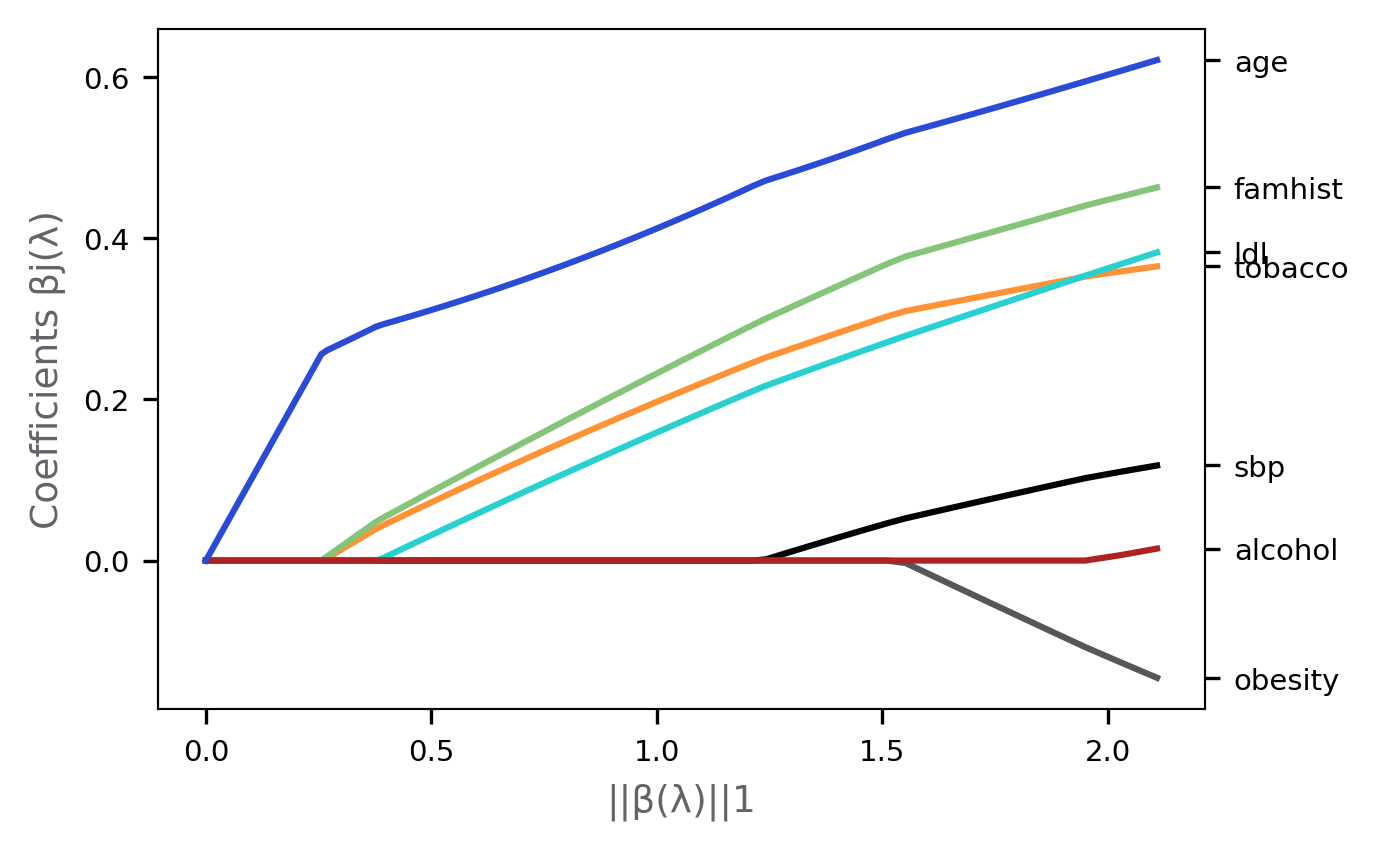

In [ ]:
lr = sm.Logit(y, sm.add_constant(StandardScaler().fit_transform(X)))
# para diferentes valores de alfa se ajusta un modelo y se guardan los coeficientes
alpha = np.linspace(0, 82, 100)
coefs = np.vstack([lr.fit_regularized(disp=False, alpha=a).params[1:]
                   for a in alpha])
# se calcula la suma de los coeficientes para los diferentes valores de alfa
coefs_l1_norm = np.sum(np.abs(coefs), axis=1)

fig, ax1 = plt.subplots(figsize=(4.5, 3), dpi=150)
colors = ['#000101', '#FF9234', '#29D0D0', '#85C57A', '#57575A', '#AD2323',
          '#2A4BD7']
for i in range(7):
    ax1.plot(coefs_l1_norm, coefs[:, i], color=colors[i])
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
plt.setp(ax2, yticks=coefs[0], yticklabels=features)
for i in ax1.get_yticklabels() + ax1.get_xticklabels() + ax2.get_yticklabels():
    i.set_fontsize(7)
ax1.set_xlabel('||β(λ)||1', color=GRAY4, fontsize=9)
_ = ax1.set_ylabel('Coefficients βj(λ)', color=GRAY4, fontsize=9)

# Trabajo 4: 

Según el gráfico cuántos parámetros se deben elegir si la magnitud del vector de parámetros con la nomra $L_1$ es igual a uno?

4: age, famhist, ldl, tobacco


Según el gráfico cuántos parámetros se deben elegir si la magnitud del vector de parámetros con la nomra $L_1$ es igual a dos?

5: tobacco, age, sbp, ldl, famhist

